In [2]:
library(ape)
library(phytools)
library(phangorn)
library(phylosignal)
library(phylobase)
library(RPANDA)
library(phylolm)

source("NeTaGFT.R")

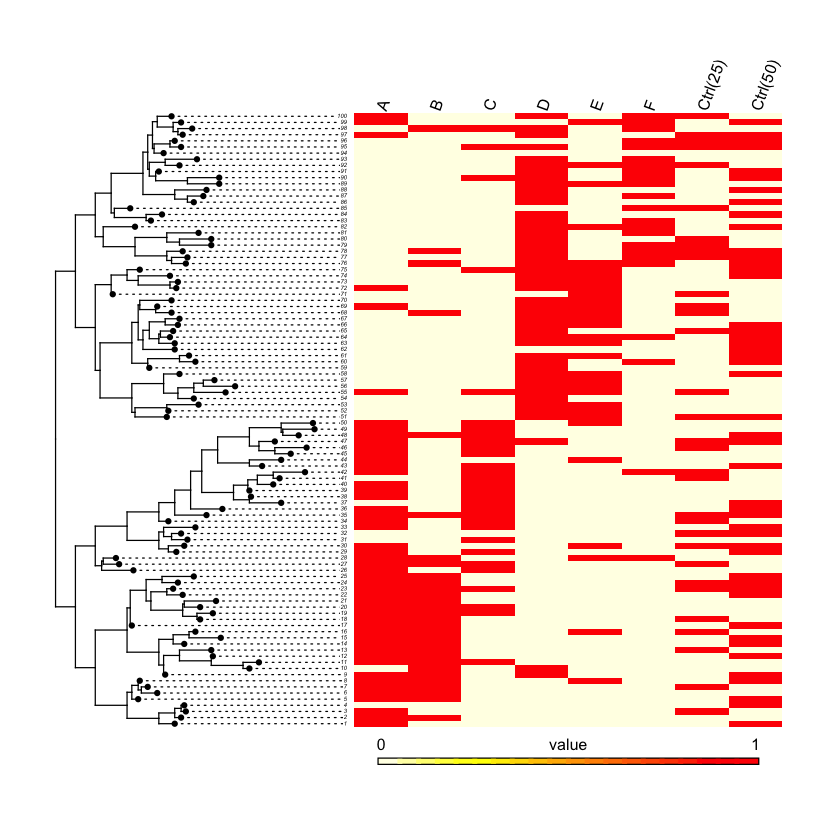

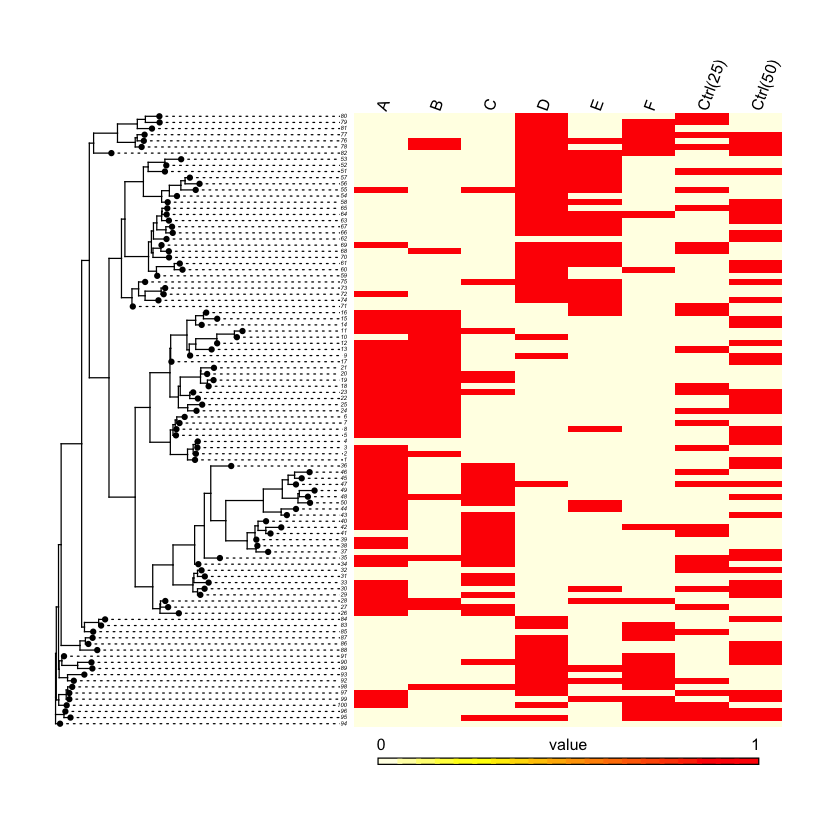

In [3]:
#error rate
beta <- 0.1

#create simulation traits
Nsub <- 25
N <- Nsub * 4
X <- matrix(0,N,8)
colnames(X) <- c("A","B","C","D","E","F","Ctrl(25)","Ctrl(50)")
X[1:(2*Nsub),1] <- 1
X[1:Nsub,2] <- 1
X[1:Nsub+Nsub,3] <- 1
X[1:(2*Nsub)+2*Nsub,4] <- 1
X[1:Nsub+2*Nsub,5] <- 1
X[1:Nsub+3*Nsub,6] <- 1
X[,7] <- sample(X[,2])
X[,8] <- sample(X[,1])

#switching with probability beta
for(i in 1:dim(X)[2]){
  for(j in 1:dim(X)[1]){
    if(runif(1) < beta){
      X[j,i] <- 1 - X[j,i]
    }
  }
}

#true tree
tree <- read.tree("dataset_simulation/truetree.nwk")
rownames(X) <- as.character(tree$tip.label)
phylo.heatmap(tree, X, fsize=c(0.3,0.8,0.8))

#reconstructed tree with fasttree
fasttree <- read.tree("dataset_simulation/fasttree.nwk")
rownames(X) <- as.character(tree$tip.label)
phylo.heatmap(fasttree, X, fsize=c(0.3,0.8,0.8))

#normalization
for(i in 1:dim(X)[2]){
  X[,i] <- X[,i]/sqrt(sum(X[,i]**2))
}

In [4]:
#Parsimony Score
fasttree <- read.tree("dataset_simulation/fasttree.nwk")
fasttree$node.label <- NULL
rownames(X) <- 1:N

PSs <- rep(0,ncol(X))
names(PSs) <- colnames(X)
for(i in 1:dim(X)[2]){
  x <- X[,i]
  names(x) <- 1:N
  PSs[i] <- parsimony(fasttree, phyDat(x, type='USER', levels=c(min(x),max(x))))
}
print(PSs)

       A        B        C        D        E        F Ctrl(25) Ctrl(50) 
      11       10       14       10       17       11       28       31 


In [5]:
#phylosignal(Cmeans)
p4d <- phylo4d(fasttree, X)
tmp <- phyloSignal(p4d = p4d, method = "all")
Cmeans <- tmp$stat$Cmean
names(Cmeans) <- colnames(X)
print(Cmeans)

            A             B             C             D             E 
 0.4991254481  0.4765970719  0.3483146532  0.5780774572  0.2875080632 
            F      Ctrl(25)      Ctrl(50) 
 0.4068310351 -0.0000129522  0.1134880163 


In [6]:
#spectR_t(fragmenter)
fragmenters <- rep(0, ncol(X))
for(i in 1:ncol(X)){
  tmp <- spectR_t(fasttree, X[fasttree$tip.label,i], draw=F)
  fragmenters[i] <- tmp$fragmenter
}
names(fragmenters) <- colnames(X)
print(fragmenters)

       A        B        C        D        E        F Ctrl(25) Ctrl(50) 
8.921060 8.891701 8.817948 9.120743 8.321387 8.898453 7.431422 7.519221 


        A         B         C         D         E         F  Ctrl(25)  Ctrl(50) 
0.4555127 0.4391281 0.5495035 0.4099944 0.6770743 0.5551768 0.9523072 0.9585717 


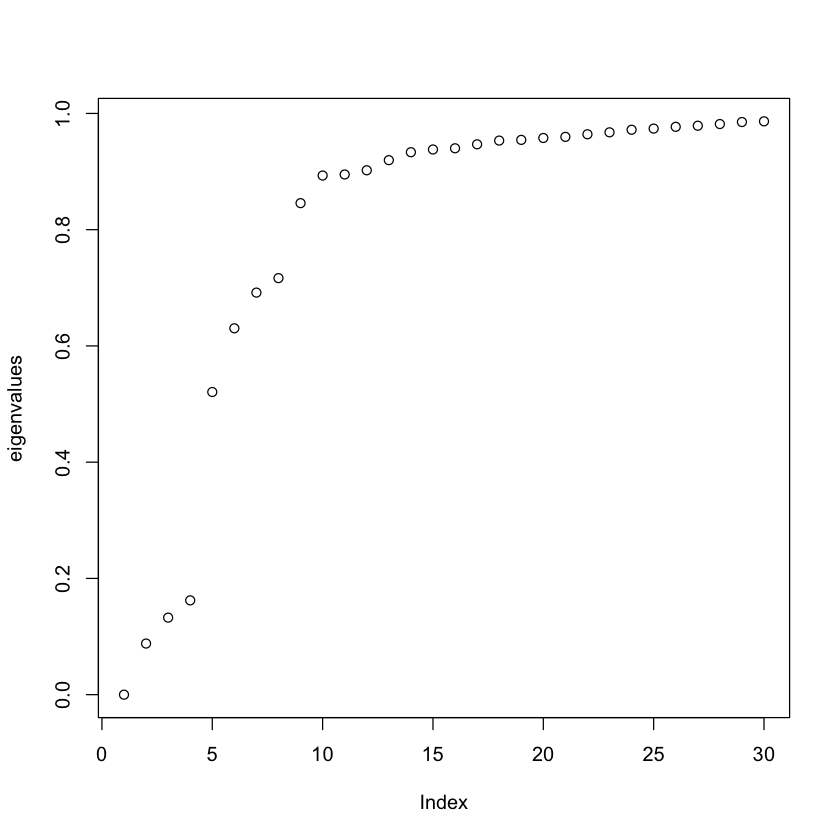

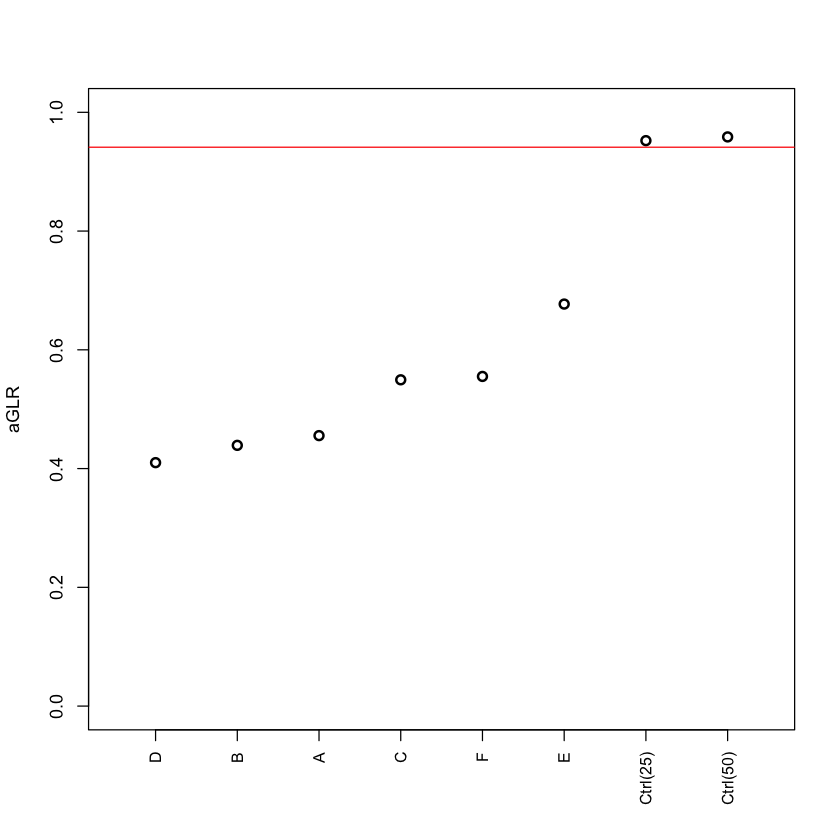

In [7]:
#aGLR
fin <- "dataset_simulation/KNN.txt"
A <- as.matrix(read.table(fin))
diag(A) <- 1
L <- sym_normalized_graph_laplacian(A)
tmp <- graph_fourier_transform(L,X,30)
U <- tmp$U
eigenvalues <- tmp$eigenvalues
hF <- tmp$hF
tF <- tmp$tF

aGLRs <- rep(0,ncol(X))
names(aGLRs) <- colnames(X)
for(i in 1:ncol(X)){
  aGLRs[i] <- graph_laplacian_regularizer(X[,i], U, eigenvalues)
}
print(aGLRs)

plot(eigenvalues)
plot_aGLR(X, U, 100)

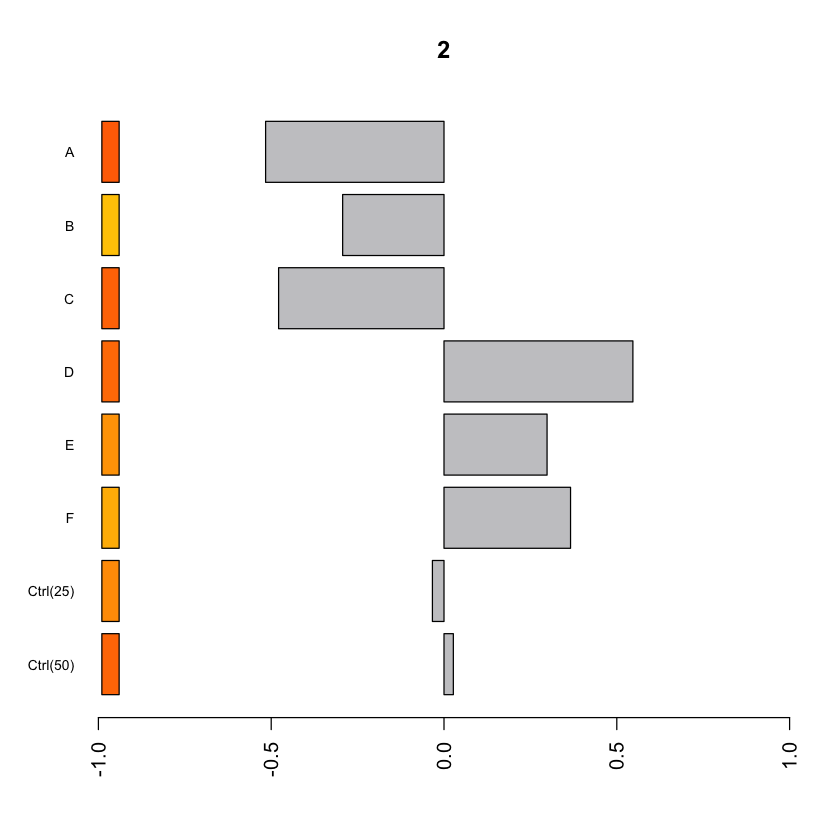

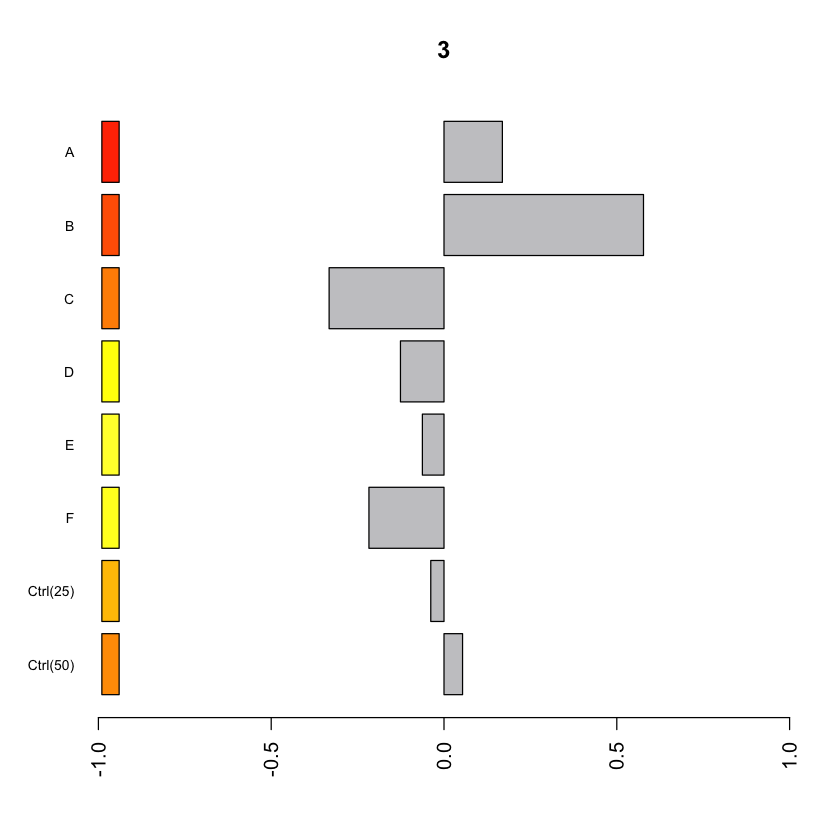

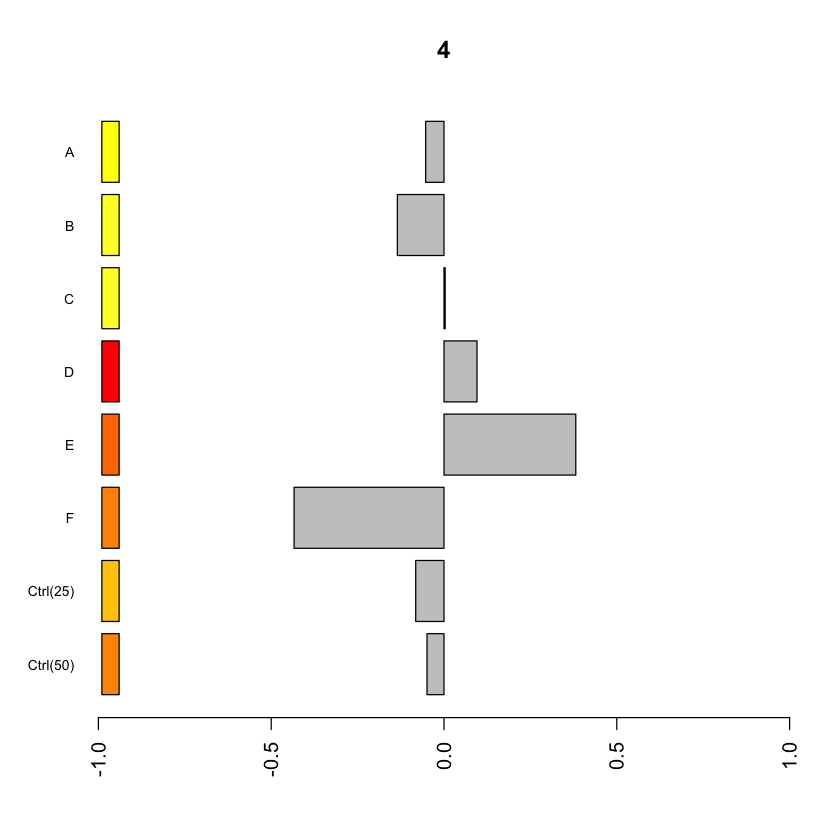

In [8]:
barplot_gfdomain(hF,tF,2)
barplot_gfdomain(hF,tF,3)
barplot_gfdomain(hF,tF,4)